In this notebook we will explore the Airbnb New York dataset and try and predict the price and the neighbourhood group.  
Ideally, we would like to understand how the specific location of a certain housing affects the price given the room type.

In [169]:
%run __base.ipynb

Exception: File `'__base.ipynb.py'` not found.

## Imports

In [170]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from math import radians
import numpy as np

## Constants

In [171]:
# We define the dataset's path
PATH = os.path.join("data", "AB_NYC_2019.csv")

## Exploratory Data Analysis

In [172]:
# We load the dataset from the disk
raw_data = pd.read_csv(PATH)

# We print a random sample 
raw_data.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
31210,24239222,little nook in astoria,74874485,Ana,Queens,Ditmars Steinway,40.77305,-73.90820,Entire home/apt,70,3,2,2018-04-12,0.13,1,0
43390,33628454,HOSTEL MY REFUGE PAISA (CAMAROTE#4 Parte Baja),248654228,Albeiro Y Katalina,Queens,East Elmhurst,40.76303,-73.88039,Shared room,34,1,2,2019-05-04,0.70,4,123
37065,29463847,NIce Bright Private Room North of Central Park,221929447,Lyn,Manhattan,Harlem,40.81226,-73.94137,Private room,45,5,5,2019-06-17,0.60,1,184
35625,28286163,Sun-drenched 3BD apt in Harlem,15439251,Willy,Manhattan,Harlem,40.82302,-73.94259,Entire home/apt,220,3,12,2019-07-03,1.29,4,230
41881,32554699,1718双个房,119692067,Qiulan,Brooklyn,Sunset Park,40.64333,-74.00227,Private room,50,1,10,2019-06-20,3.16,3,71


In [173]:
# We look at the shape of our dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

From the previous two cells we notice two things:  
    - The last_review and reviews_per_month variables contain several NaNs.  
    - There are several inconsistencies in the dataset: namely housing that is available 0 days a year, i.e that has its availability_365 set to zero, or that has the price variable set to zero.   
    - There are unecessary variables for both prediction tasks, such as host_name and name ... etc   

Thus we decide to get rid of the inconsistencies, NaNs and unecessary variables.   
Note that for the NaNs we could've proceeded otherwise, by filling the missing data points by the mean (or the median as it is a more robust statistic) or by building models out of the other variables and try to infer them (as there might be correlations !), but given the size of our dataset we choose to drop them. 


In [174]:
# Dropping previously mentionned inconsistencies and NaNs
raw_data = raw_data[(raw_data.availability_365 > 0) & ~(raw_data.reviews_per_month.isna()) & (raw_data.price > 0)]

# Dropping unecessary variables
raw_data = raw_data.drop(columns=["name", "host_id", "host_name"])

In [175]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26147 entries, 0 to 48852
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              26147 non-null  int64  
 1   neighbourhood_group             26147 non-null  object 
 2   neighbourhood                   26147 non-null  object 
 3   latitude                        26147 non-null  float64
 4   longitude                       26147 non-null  float64
 5   room_type                       26147 non-null  object 
 6   price                           26147 non-null  int64  
 7   minimum_nights                  26147 non-null  int64  
 8   number_of_reviews               26147 non-null  int64  
 9   last_review                     26147 non-null  object 
 10  reviews_per_month               26147 non-null  float64
 11  calculated_host_listings_count  26147 non-null  int64  
 12  availability_365                

We start by investigating our endogenous variables:  
    - Price  
    - Neighbourhood Group

<AxesSubplot:ylabel='Density'>

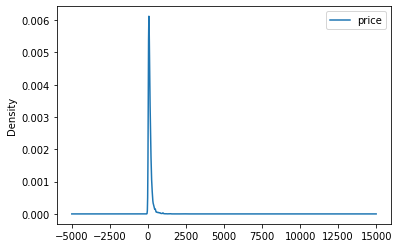

In [176]:
# We plot the distribution of the prices
raw_data[["price"]].plot(kind="kde")

The prices distribution seem be very right skewed, i.e following a log normal distribution. Thus, a logarithmic transformation will help us simplify our asumptions and apply easily our models on the dataset ! 

In [177]:
# We apply the log transformation on the price
raw_data["log_price"] = np.log(1 + raw_data.loc[:, "price"])

Now if we plot again the distribution, it looks a lot better.  
We also compute the kurtosis, which is the fourth standardized moment of a distribution defined by $E[(\frac{X - \mu}{\sigma})^4]$ for a normal distribution it should be 0.   
In our case, when we apply the log transformation it does get pretty close to zero ! 

price        638.584751
log_price      0.887869
dtype: float64

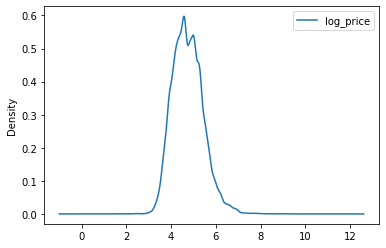

In [10]:
# We plot the log distribution 
raw_data[["log_price"]].plot(kind="kde")

# We compute the Kurtosis for the price and the log price
raw_data[["price", "log_price"]].kurtosis()

We explore the relationship between the neighbourhood and price, and the relationship between the room thype and price, by plotting the boxplot of the distributions

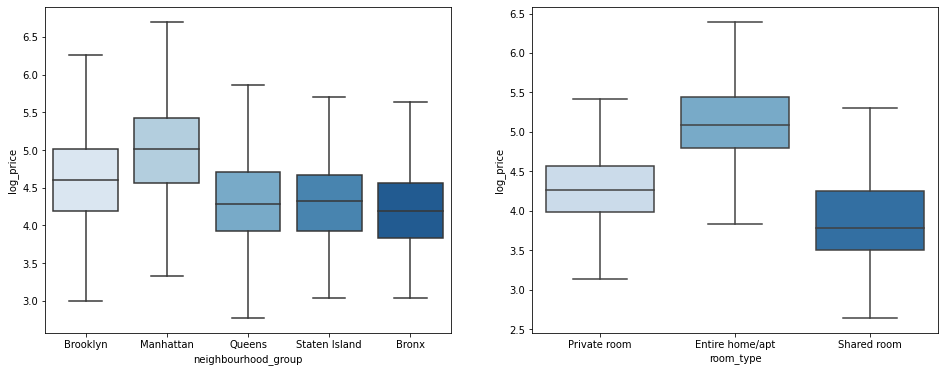

In [11]:
box_plot_features = ['neighbourhood_group', "room_type"]

fig, axes = plt.subplots(1, len(box_plot_features), figsize=(16, 6))

for var, ax in zip(box_plot_features, axes.flat):
    sns.boxplot(x=var,
                y='log_price',
                data=raw_data,
                showfliers=False,
                ax=ax,
                palette='Blues')

There is a clear difference between the following distributions   
However, one might worry that between the difference is not statistically significant between Queens and Staten Island.  
Thus we perform an ANOVA test shows that indeed they are statistically significantly different. In this test we assume homoscedasticity. 

In [12]:
# ANOVA F-test
f_oneway(*[data["log_price"] for grp, data in raw_data.groupby("neighbourhood_group")])

F_onewayResult(statistic=1089.6186431900253, pvalue=0.0)

One thing to note is that our dataset is not balanced along the neighbourhoods 

In [13]:
# We compute the number of housings available per location 
raw_data.groupby(["neighbourhood_group", "neighbourhood"]).count()[["price"]].rename(columns={"price": "count"}).sort_values("count", ascending=False,)

count
neighbourhood_group neighbourhood            
Brooklyn            Bedford-Stuyvesant   2208
                    Williamsburg         1785
Manhattan           Harlem               1508
Brooklyn            Bushwick             1214
Manhattan           Hell's Kitchen       1191
...                                       ...
Staten Island       Rossville               1
                    Silver Lake             1
                    Prince's Bay            1
                    Bull's Head             1
                    Willowbrook             1

[217 rows x 1 columns]

<AxesSubplot:xlabel='neighbourhood_group', ylabel='count'>

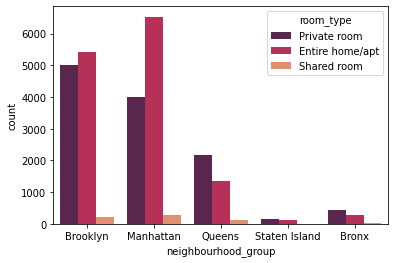

In [14]:
# We plot the type of housings available per nieghborhoud group.
sns.countplot(x = 'neighbourhood_group', data = raw_data, hue = 'room_type', palette = 'rocket')

We finally investigate correlations between the exogenous variables, we find a small correlation between the number of reviews and the reviews per month, however between the other variables there is almost none. So we can proceed with the prediction tasks, without any problem !  

<AxesSubplot:>

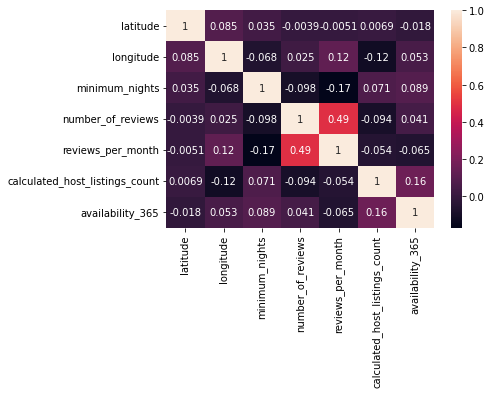

In [15]:
sns.heatmap(raw_data.drop(columns=["price", "log_price", "neighbourhood_group", "id"]).corr(), annot=True)

## Neighbourhood Groups Classification


Usually, for this kind of tasks, we would not use models to predict as the relationship between longitude, lattitude and the neighbourhood is deterministic.  
However, for the sake of the exercise we predict this using a KNN and the haversine distance explained in this [link](https://stackoverflow.com/questions/37324332/how-to-find-the-nearest-neighbors-for-latitude-and-longitude-point-on-python).  

In [126]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn_pandas import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


FEATURES = ["longitude", "latitude"]
TARGET = ["neighbourhood_group"]


mapper = DataFrameMapper([(col,  LabelEncoder()) for col in TARGET], df_out=True)


data = pd.concat([mapper.fit_transform(raw_data), raw_data[FEATURES].applymap(radians)], axis=1)

data




,neighbourhood_group,longitude,latitude
0,1,-1.291061,0.709433
1,2,-1.291260,0.711285
3,1,-1.290841,0.710090
5,2,-1.291107,0.711181
7,2,-1.291281,0.711482
...,...,...,...
48782,2,-1.290735,0.711763
48790,3,-1.288308,0.711240
48799,4,-1.294035,0.707588
48805,0,-1.290217,0.712232


While splitting our dataset into a train-test we stratify on the neighbourhood_group that way we keep the same sample distribution in both samples. 

In [20]:
df_train, df_test = train_test_split(
                        data, test_size=0.2, random_state=42069, stratify=data["neighbourhood_group"]
                    )
X_train, X_test = df_train[FEATURES], df_test[FEATURES]
y_train, y_test = df_train[TARGET], df_test[TARGET]
#model = LogisticRegression()

As a metric for the cross validation we use the F1 score, given our mutliclass classification task is pretty unbalanced. Using the binary accuracy might be missleading !

In [25]:
results = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=k, weights="distance", metric="haversine"), X_train, y_train.values.ravel(), cv=3, scoring='f1_macro',  n_jobs=-1)) for k in tqdm(range(2, 100))]    

100%|██████████| 98/98 [03:40<00:00,  2.25s/it]


In [29]:
K = np.argmax(results) + 2
K

2

<AxesSubplot:>

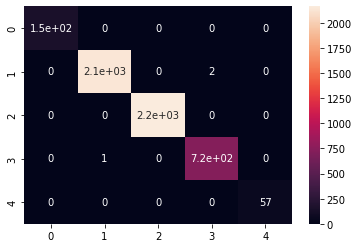

In [33]:
from sklearn.metrics import confusion_matrix

knn_model = KNeighborsClassifier(n_neighbors=K, weights="distance", metric="haversine")
knn_model.fit(X_train, y_train.values.ravel())
sns.heatmap(confusion_matrix(knn_model.predict(X_test), y_test.values.ravel()), annot=True)

We obtain an almost perfect classification from the KNN model.

## Price regression

We start with a simple linear regression (Ordinary least squares) on the log price.  
This will allow us to have a lot of interpretability and infer the effect of the precise localisation on the price.

In [50]:
SCALED_COLS = ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]
BINARIZED_COLS = ["neighbourhood", "room_type"]
TARGET = ["log_price"]


mapper = DataFrameMapper(  
                                [([col], OneHotEncoder()) for col in BINARIZED_COLS]
                                + [([col], MinMaxScaler()) for col in SCALED_COLS],
                        df_out=True,
                    )


data = pd.concat([raw_data[TARGET], mapper.fit_transform(raw_data)], axis=1)


data

/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,log_price,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,neighbourhood_x0_Bay Terrace,...,neighbourhood_x0_Woodlawn,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,5.010635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.012739,0.003419,0.015337,1.000000
1,5.420535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.070064,0.006326,0.003067,0.972527
3,4.499810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.428344,0.079159,0.000000,0.530220
5,5.303305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.001601,0.116242,0.009916,0.000000,0.351648
7,4.382027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000801,0.683121,0.059155,0.000000,0.601648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,4.867534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.401099
48790,3.828641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.015337,0.928571
48799,5.463832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.236264
48805,4.615121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.001592,0.034023,0.000000,0.107143


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )

In [52]:
model = sm.OLS(y_train, X_train)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     127.6
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        22:19:19   Log-Likelihood:                -12642.
No. Observations:               20917   AIC:                         2.573e+04
Df Residuals:                   20696   BIC:                         2.748e+04
Df Model:                         220                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
neighbourhood_x0_Allerton                     -0.0504      0.093     -0.542      0.588      -0.233       0.132
neighbourhood_x0_Arden Heights                -0.4930      0.314     -1.572      0.116      -1.108       0.122
neighbourhood_x0_Arrochar                     -0.1561      0.111     -1.402      0.161      -0.374       0.062
neighbourhood_x0_Arverne                       0.2540      0.063      4.027      0.000       0.130       0.378
neighbourhood_x0_Astoria                       0.1001      0.026      3.886      0.000       0.050       0.151
neighbourhood_x0_Bath Beach                   -0.1501      0.148     -1.013      0.311      -0.441       0.140
neighbourhood_x0_Battery Park City             0.4266      0.128      3.321      0.001       0.175       0.678
neighbourhood_x0_Bay Ridge                     0.1079      0.056      1.938      0.053      -0.001       0.217
neighbourhood_x0_Bay Terrace                   0.2821      0.199      1.421      0.155      -0.107       0.671
neighbourhood_x0_Baychester                   -0.1122      0.199     -0.565      0.572      -0.501       0.277
neighbourhood_x0_Bayside                       0.0584      0.105      0.556      0.578      -0.148       0.264
neighbourhood_x0_Bayswater                    -0.0721      0.148     -0.487      0.627      -0.362       0.218
neighbourhood_x0_Bedford-Stuyvesant            0.0671      0.015      4.365      0.000       0.037       0.097
neighbourhood_x0_Belle Harbor                  0.2035      0.256      0.795      0.427      -0.298       0.706
neighbourhood_x0_Bellerose                     0.0225      0.199      0.113      0.910      -0.367       0.412
neighbourhood_x0_Belmont                      -0.1450      0.123     -1.174      0.240      -0.387       0.097
neighbourhood_x0_Bensonhurst                  -0.1942      0.073     -2.669      0.008      -0.337      -0.052
neighbourhood_x0_Bergen Beach                 -0.1426      0.168     -0.849      0.396      -0.472       0.187
neighbourhood_x0_Boerum Hill                   0.4395      0.055      7.997      0.000       0.332       0.547
neighbourhood_x0_Borough Park                 -0.1405      0.053     -2.644      0.008      -0.245      -0.036
neighbourhood_x0_Breezy Point                  1.1568      0.314      3.689      0.000       0.542       1.771
neighbourhood_x0_Briarwood                    -0.0977      0.082     -1.196      0.232      -0.258       0.062
neighbourhood_x0_Brighton Beach               -0.0401      0.070     -0.572      0.567      -0.178       0.097
neighbourhood_x0_Bronxdale                    -0.4719      0.157     -3.004      0.003      -0.780      -0.164
neighbourhood_x0_Brooklyn Heights              0.5555      0.063      8.883      0.000

In [67]:
y_pred = model_results.predict(X_test)

pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=["test scores"])

,R^2,mean absolute error,mean squared error
test scores,0.570856,0.323872,0.198005


In [54]:
from sklearn.linear_model import RidgeCV


model_ridge = RidgeCV(alphas=np.linspace(0.001, 20, 1000), fit_intercept=False)

model_ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 2.10190190e-02, 4.10380380e-02, 6.10570571e-02,
       8.10760761e-02, 1.01095095e-01, 1.21114114e-01, 1.41133133e-01,
       1.61152152e-01, 1.81171171e-01, 2.01190190e-01, 2.21209209e-01,
       2.41228228e-01, 2.61247247e-01, 2.81266266e-01, 3.01285285e-01,
       3.21304304e-01, 3.41323323e-01, 3.61342342e-01, 3.81361361e-01,
       4.01380380e-01, 4.21399399e-0...
       1.95395626e+01, 1.95595816e+01, 1.95796006e+01, 1.95996196e+01,
       1.96196386e+01, 1.96396577e+01, 1.96596767e+01, 1.96796957e+01,
       1.96997147e+01, 1.97197337e+01, 1.97397528e+01, 1.97597718e+01,
       1.97797908e+01, 1.97998098e+01, 1.98198288e+01, 1.98398478e+01,
       1.98598669e+01, 1.98798859e+01, 1.98999049e+01, 1.99199239e+01,
       1.99399429e+01, 1.99599620e+01, 1.99799810e+01, 2.00000000e+01]),
        fit_intercept=False)

In [57]:
model_ridge.score(X_train, y_train), model_ridge.alpha_

(0.574824316405259, 1.6025215215215214)

In [66]:
y_pred = model_ridge.predict(X_test)

pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=[f"test scores for alpha {model_ridge.alpha_}"])

,R^2,mean absolute error,mean squared error
test scores for alpha 1.6025215215215214,0.569679,0.324392,0.198548


In [87]:
df = pd.DataFrame([model_results.params.tolist(), model_results.pvalues.tolist()], columns=X_train.columns, index=["Coefficients", "Pvalues"])
df

,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,neighbourhood_x0_Bay Terrace,neighbourhood_x0_Baychester,...,neighbourhood_x0_Woodlawn,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
Coefficients,-0.050419,-0.493007,-0.156119,0.253992,0.100089,-0.150117,0.426610,0.107935,0.282063,-0.112191,...,-0.403275,-0.002917,4.776722,4.058923,3.609692,-3.307224e+00,-3.805127e-01,-0.142428,-2.061124e-01,2.162645e-01
Pvalues,0.588151,0.115923,0.161012,0.000057,0.000102,0.310945,0.000898,0.052691,0.155426,0.571965,...,0.026112,0.947542,0.000000,0.000000,0.000000,6.940657e-65,1.072700e-19,0.244687,2.272724e-07,4.099257e-114


In [88]:
cols = list(filter(lambda x: x.startswith("neighbourhood"), list(df.columns)))


df = df[cols].T.reset_index().rename(columns={"index":"neighbourhood"})
df["neighbourhood"] = df["neighbourhood"].str.split("_").apply(lambda x: x[-1])
df["significance"] = df["Pvalues"].apply(lambda x: "significant" if x < 0.05 else "no affirmation")
df

,neighbourhood,Coefficients,Pvalues,significance
0,Allerton,-0.050419,0.588151,no affirmation
1,Arden Heights,-0.493007,0.115923,no affirmation
2,Arrochar,-0.156119,0.161012,no affirmation
3,Arverne,0.253992,0.000057,significant
4,Astoria,0.100089,0.000102,significant
...,...,...,...,...
212,Willowbrook,0.552139,0.212985,no affirmation
213,Windsor Terrace,0.115859,0.030257,significant
214,Woodhaven,-0.245912,0.000115,significant
215,Woodlawn,-0.403275,0.026112,significant


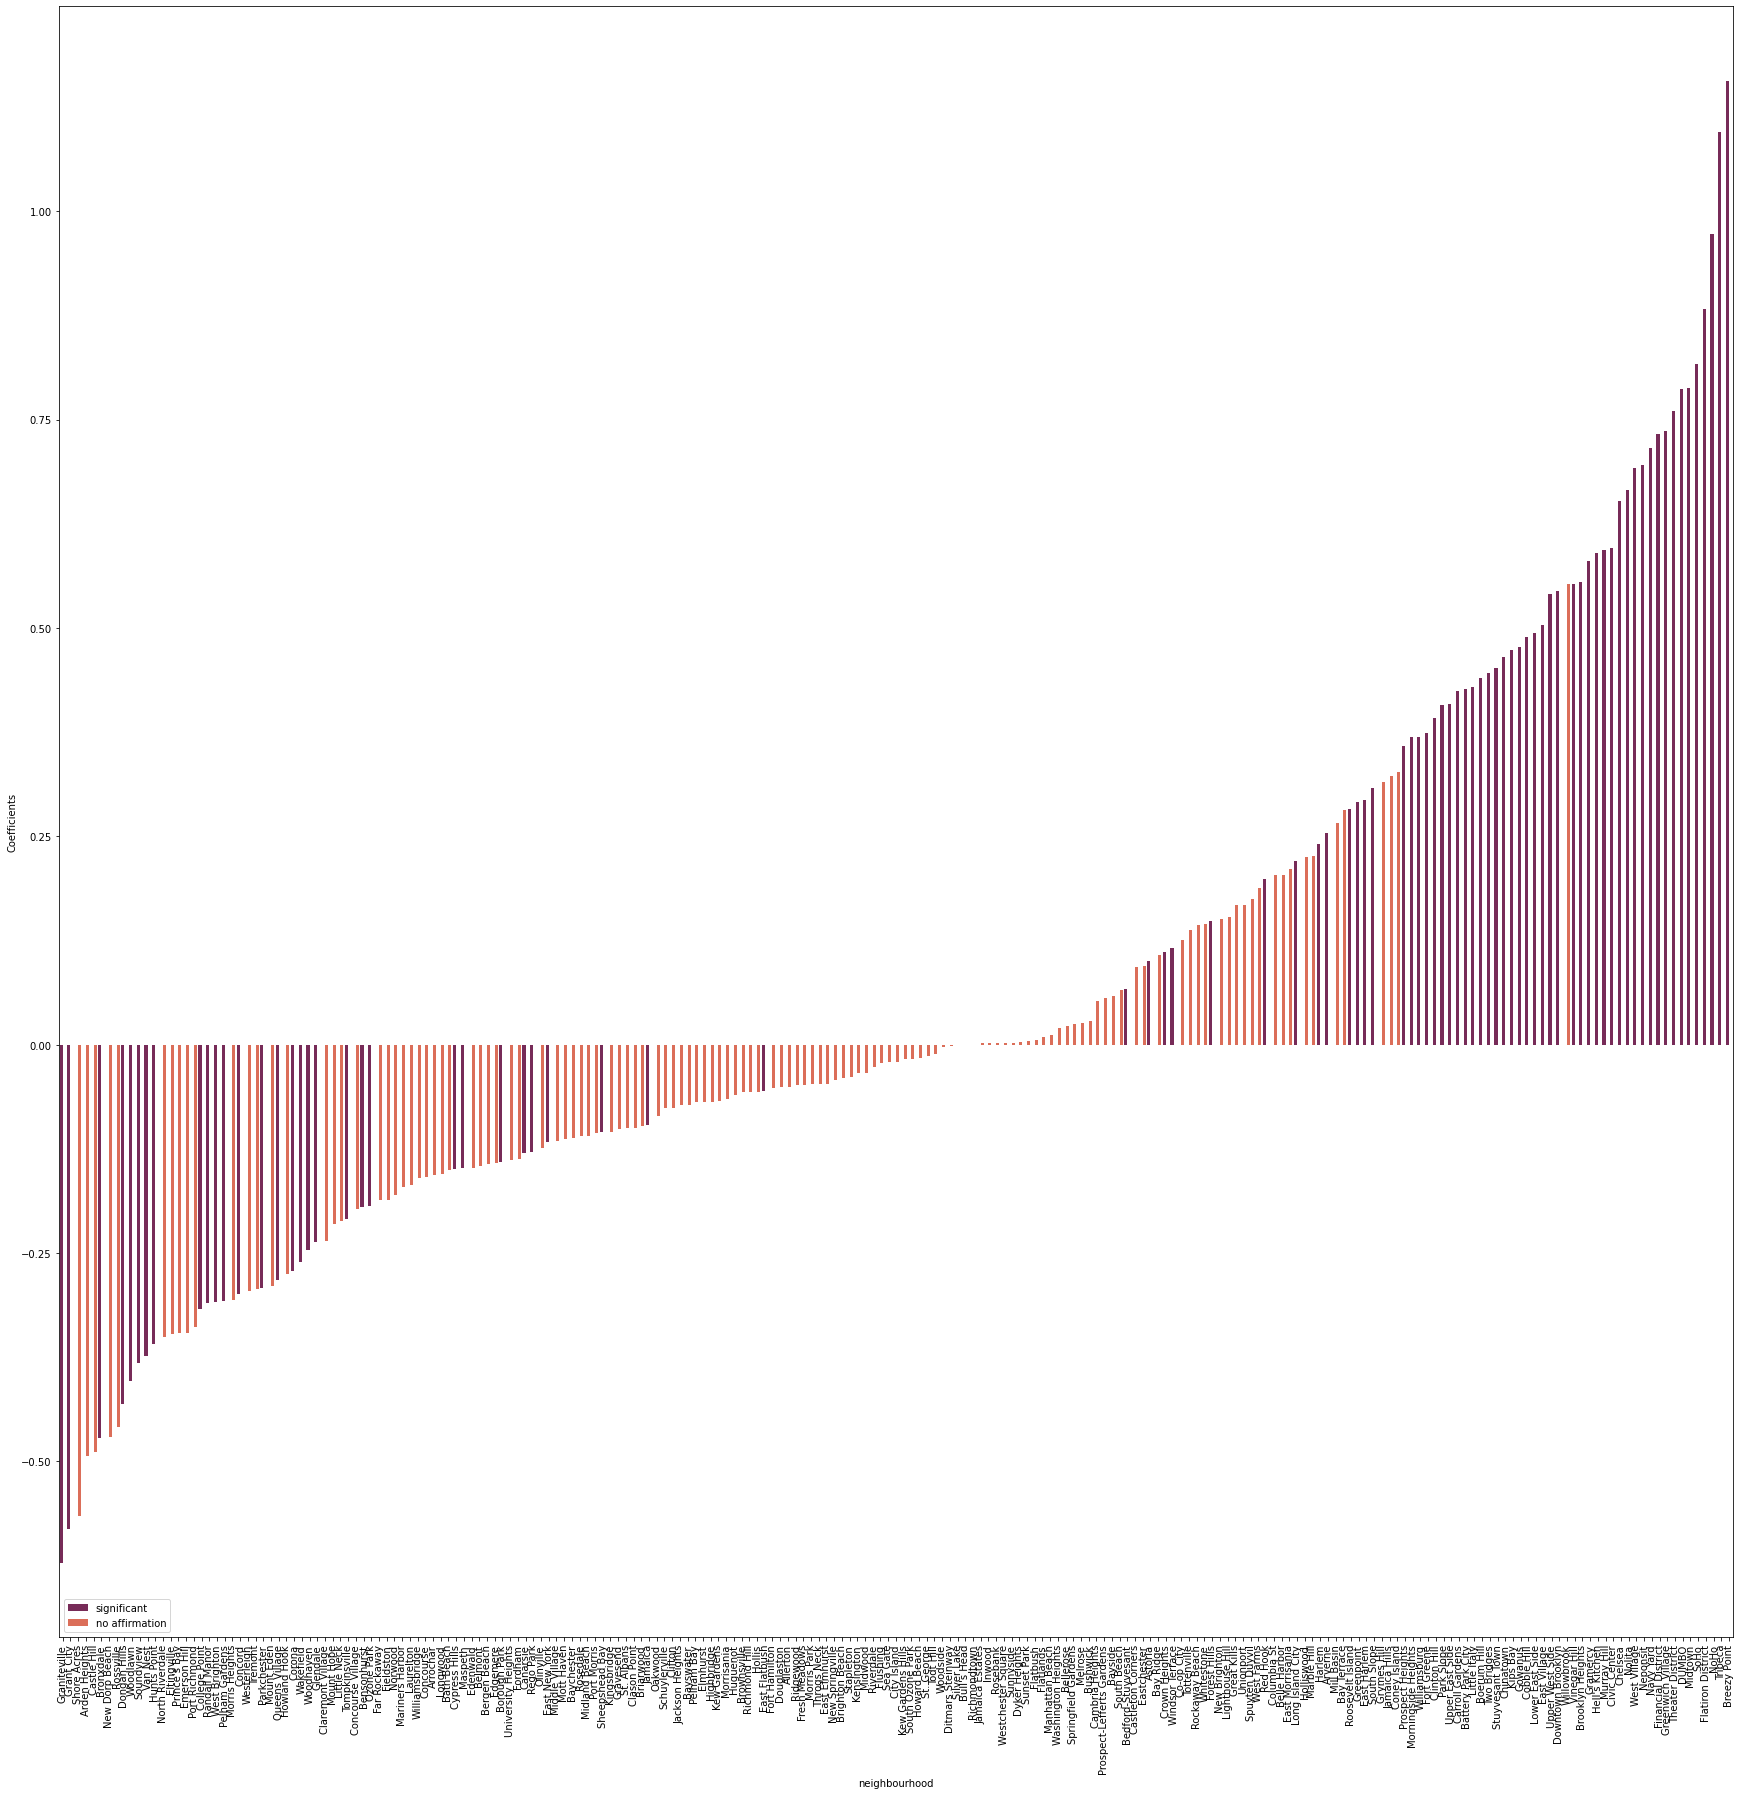

In [97]:
plt.figure(figsize=(30, 30))
sns.barplot(x = 'neighbourhood', y = "Coefficients", data = df.sort_values(["Coefficients"]), hue = 'significance', palette = 'rocket', orient= "v")
plt.xticks(rotation=90)
plt.legend()


In [98]:
raw_data.merge(df, on="neighbourhood")

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price,Coefficients,Pvalues,significance
0,2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,5.010635,-0.033742,0.541837,no affirmation
1,63546,Brooklyn,Kensington,40.64106,-73.97426,Private room,39,1,45,2019-05-16,0.46,2,365,3.688879,-0.033742,0.541837,no affirmation
2,125594,Brooklyn,Kensington,40.64302,-73.97255,Private room,39,1,82,2019-05-19,0.94,2,365,3.688879,-0.033742,0.541837,no affirmation
3,267652,Brooklyn,Kensington,40.64277,-73.97296,Private room,60,2,20,2019-01-21,0.42,1,347,4.110874,-0.033742,0.541837,no affirmation
4,282341,Brooklyn,Kensington,40.64330,-73.97386,Entire home/apt,90,30,3,2017-07-30,0.05,1,286,4.510860,-0.033742,0.541837,no affirmation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26142,32306527,Queens,Jamaica Hills,40.71686,-73.79742,Private room,67,2,25,2019-07-07,6.88,2,318,4.219508,0.322635,0.104284,no affirmation
26143,33469440,Queens,Jamaica Hills,40.71022,-73.79665,Entire home/apt,110,2,8,2019-06-29,3.16,1,81,4.709530,0.322635,0.104284,no affirmation
26144,33957835,Queens,Jamaica Hills,40.71757,-73.79610,Private room,65,1,1,2019-07-07,1.00,2,139,4.189655,0.322635,0.104284,no affirmation
26145,35057815,Queens,Jamaica Hills,40.71209,-73.80151,Entire home/apt,325,2,4,2019-07-08,4.00,2,124,5.786897,0.322635,0.104284,no affirmation


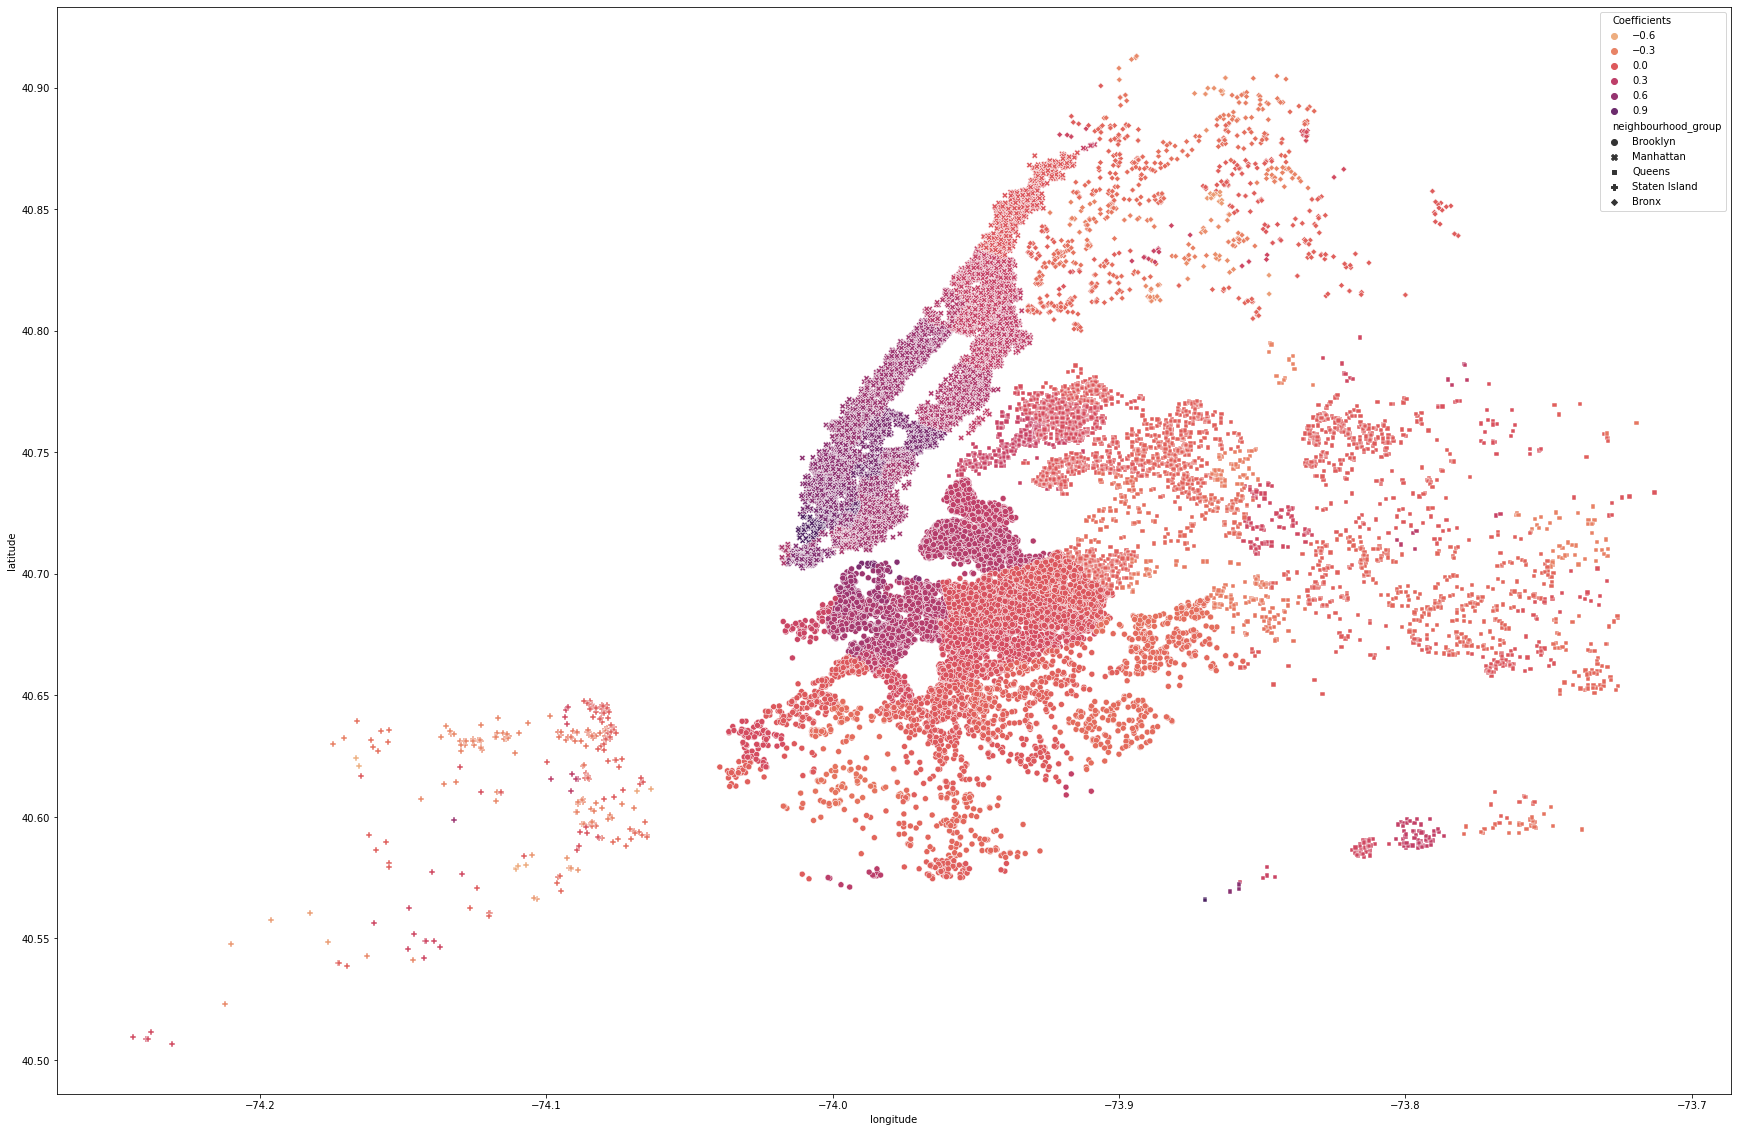

In [101]:

df_plot = raw_data.merge(df, on="neighbourhood")
fig, ax = plt.subplots(1, figsize=(30, 20))

#ax[0] = sns.scatterplot(data=df_plot, x="longitude", y="latitude", hue="neighbourhood_group")
ax = sns.scatterplot(data=df_plot, x="longitude", y="latitude", hue="Coefficients", style="neighbourhood_group", palette=sns.color_palette("flare", as_cmap=True))


In [122]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

model_XGB = GradientBoostingRegressor(max_features="log2")

param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth" : [1, 3, 15, 30]
}
XGB_grid_model = GridSearchCV(estimator = model_XGB, param_grid = param_grid,
                             scoring = 'r2', cv = 3, n_jobs=-1, verbose=10,)

XGB_grid_model.fit(X_train, y_train.values.ravel())

XGB_grid_model.score(X_train, y_train.values.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START max_depth=1, n_estimators=100..............................
[CV 2/3; 1/12] START max_depth=1, n_estimators=100..............................
[CV 3/3; 1/12] START max_depth=1, n_estimators=100..............................
[CV 1/3; 2/12] START max_depth=1, n_estimators=150..............................
[CV 2/3; 2/12] START max_depth=1, n_estimators=150..............................
[CV 3/3; 2/12] START max_depth=1, n_estimators=150..............................
[CV 1/3; 3/12] START max_depth=1, n_estimators=200..............................
[CV 2/3; 3/12] START max_depth=1, n_estimators=200..............................
[CV 1/3; 1/12] END max_depth=1, n_estimators=100;, score=0.332 total time=   0.5s
[CV 3/3; 3/12] START max_depth=1, n_estimators=200..............................
[CV 2/3; 1/12] END max_depth=1, n_estimators=100;, score=0.180 total time=   0.6s
[CV 1/3; 4/12] START max_depth=3, n_estimators

0.8662781718195367

In [124]:
y_pred = XGB_grid_model.predict(X_test)
pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=[f"test scores for alpha {model_ridge.alpha_}"])

,R^2,mean absolute error,mean squared error
test scores for alpha 1.6025215215215214,0.620611,0.304517,0.175048


In [180]:
raw_data[["longitude, latitude"]]

KeyError: "None of [Index(['longitude, latitude'], dtype='object')] are in the [columns]"

In [181]:
SCALED_COLS = ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]
BINARIZED_COLS = ["neighbourhood", "room_type"]
TARGET = ["log_price"]
FEATURES = SCALED_COLS


mapper = DataFrameMapper(  
                                [([col], OneHotEncoder()) for col in BINARIZED_COLS]
                                + [([col], MinMaxScaler()) for col in SCALED_COLS],
                        df_out=True,
                    )


data = pd.concat([raw_data[["longitude", "latitude"]], mapper.fit_transform(raw_data)], axis=1)

data[TARGET] = raw_data[TARGET]

data

/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/tmp/ipykernel_12259/1467467743.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[TARGET] = raw_data[TARGET]


,longitude,latitude,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,...,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
0,-73.97237,40.64749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.012739,0.003419,0.015337,1.000000,5.010635
1,-73.98377,40.75362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.070064,0.006326,0.003067,0.972527,5.420535
3,-73.95976,40.68514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.428344,0.079159,0.000000,0.530220,4.499810
5,-73.97500,40.74767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.001601,0.116242,0.009916,0.000000,0.351648,5.303305
7,-73.98493,40.76489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000801,0.683121,0.059155,0.000000,0.601648,4.382027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,-73.95366,40.78099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.401099,4.867534
48790,-73.81459,40.75104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.015337,0.928571,3.828641
48799,-74.14275,40.54179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.236264,5.463832
48805,-73.92400,40.80787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.001592,0.034023,0.000000,0.107143,4.615121


In [182]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )

from sklearn.metrics.pairwise import haversine_distances
data["neighbour_price"] = [y_train[["log_price"]].iloc[np.argsort(haversine_distances(x.values.reshape(-1, 2), X_train[["longitude", "latitude"]].values)).flatten()[1]].values.item() for _, x in tqdm(data[["longitude", "latitude"]].iterrows())] 

26147it [02:08, 202.98it/s]


In [183]:
data[["neighbour_price", "log_price"]]

,neighbour_price,log_price
0,3.828641,5.010635
1,4.615121,5.420535
3,4.564348,4.499810
5,5.351858,5.303305
7,5.198497,4.382027
...,...,...
48782,4.700480,4.867534
48790,4.189655,3.828641
48799,3.713572,5.463832
48805,3.912023,4.615121


In [184]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(columns=TARGET+["longitude", "latitude"]), data[TARGET], test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )

In [185]:
X_train

,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,neighbourhood_x0_Bay Terrace,neighbourhood_x0_Baychester,...,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbour_price
1247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.004804,0.128981,0.016584,0.000000,0.109890,5.303305
14344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.023219,0.011146,0.003590,0.033742,0.046703,5.135798
45786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.010408,0.000000,0.016926,0.000000,0.002747,5.303305
36888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000801,0.001592,0.004616,0.000000,0.142857,5.198497
46546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.001601,0.003185,0.051120,0.000000,0.725275,4.615121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000801,0.148089,0.055394,0.000000,0.456044,4.394449
21720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000801,0.095541,0.036416,0.006135,0.112637,4.521789
1468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.550955,0.072320,0.003067,0.675824,4.615121
6969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.066879,0.013849,0.000000,0.065934,5.525453


In [188]:
model_ridge = RidgeCV(alphas=np.linspace(0.001, 20, 1000), fit_intercept=False)

model_ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 2.10190190e-02, 4.10380380e-02, 6.10570571e-02,
       8.10760761e-02, 1.01095095e-01, 1.21114114e-01, 1.41133133e-01,
       1.61152152e-01, 1.81171171e-01, 2.01190190e-01, 2.21209209e-01,
       2.41228228e-01, 2.61247247e-01, 2.81266266e-01, 3.01285285e-01,
       3.21304304e-01, 3.41323323e-01, 3.61342342e-01, 3.81361361e-01,
       4.01380380e-01, 4.21399399e-0...
       1.95395626e+01, 1.95595816e+01, 1.95796006e+01, 1.95996196e+01,
       1.96196386e+01, 1.96396577e+01, 1.96596767e+01, 1.96796957e+01,
       1.96997147e+01, 1.97197337e+01, 1.97397528e+01, 1.97597718e+01,
       1.97797908e+01, 1.97998098e+01, 1.98198288e+01, 1.98398478e+01,
       1.98598669e+01, 1.98798859e+01, 1.98999049e+01, 1.99199239e+01,
       1.99399429e+01, 1.99599620e+01, 1.99799810e+01, 2.00000000e+01]),
        fit_intercept=False)

In [190]:
y_pred = model_ridge.predict(X_test)

pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=["test scores"])

,R^2,mean absolute error,mean squared error
test scores,0.571714,0.323728,0.19761
